In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io,segmentation,future,color,data,feature,measure,morphology,filters,util,restoration
from scipy import ndimage
import matplotlib.patches as mpatches
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from sklearn.decomposition import DictionaryLearning

PATH = '/content/image_processing'

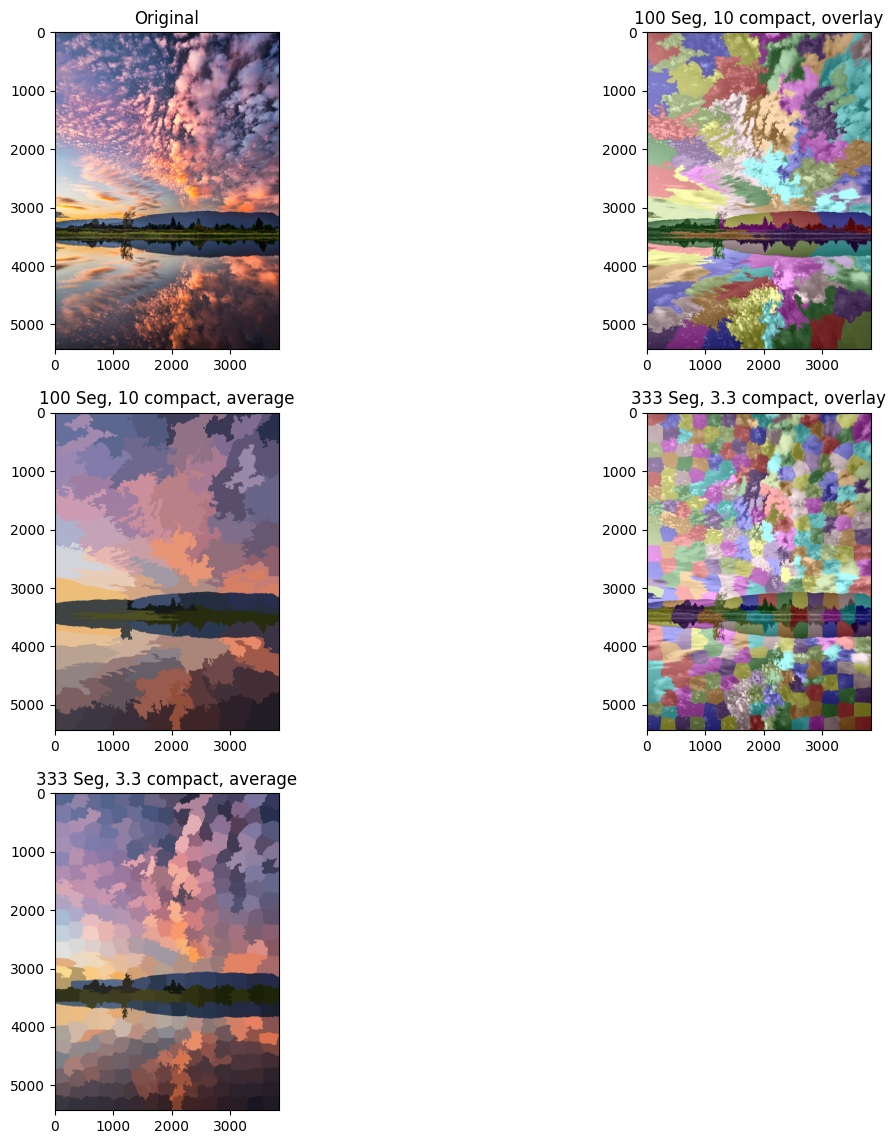

In [ ]:
img = io.imread('/content/image_processing/vibrant.jpeg')
label1 = segmentation.slic(img)
label2 = segmentation.slic(img,n_segments=333,compactness=33)

overlay1_1 = color.label2rgb(label1,img,kind='overlay')
overlay1_2 = color.label2rgb(label1,img,kind='avg')
overlay2_1 = color.label2rgb(label2,img,kind='overlay')
overlay2_2 = color.label2rgb(label2,img,kind='avg')

f,ax = plt.subplots(3,2,figsize=(14,14))
ax = ax.ravel()

ax[0].imshow(img)
ax[0].set_title('Original')

ax[1].imshow(overlay1_1)
ax[1].set_title('100 Seg, 10 compact, overlay')

ax[2].imshow(overlay1_2)
ax[2].set_title('100 Seg, 10 compact, average')

ax[3].imshow(overlay2_1)
ax[3].set_title('333 Seg, 3.3 compact, overlay')

ax[4].imshow(overlay2_2)
ax[4].set_title('333 Seg, 3.3 compact, average')

f.delaxes(ax[-1])
plt.show()

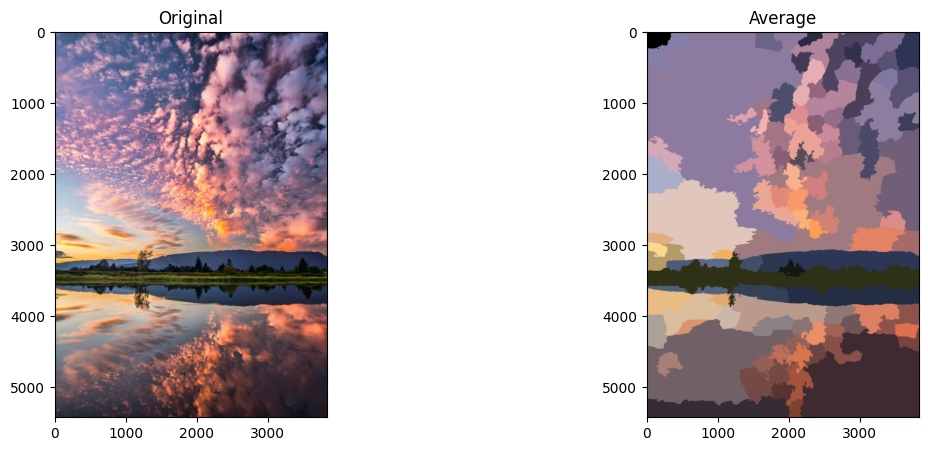

In [ ]:
rag = future.graph.rag_mean_color(img,label2,connectivity=3,mode='distance',sigma=321)
new_labels = future.graph.cut_threshold(label2,rag,thresh=27)

rag_img_avg = color.label2rgb(new_labels,img,kind='avg')

f,ax = plt.subplots(1,2,figsize=(14,5))
ax = ax.ravel()

ax[0].imshow(img)
ax[0].set_title('Original')

ax[1].imshow(rag_img_avg)
ax[1].set_title('Average')
plt.show()

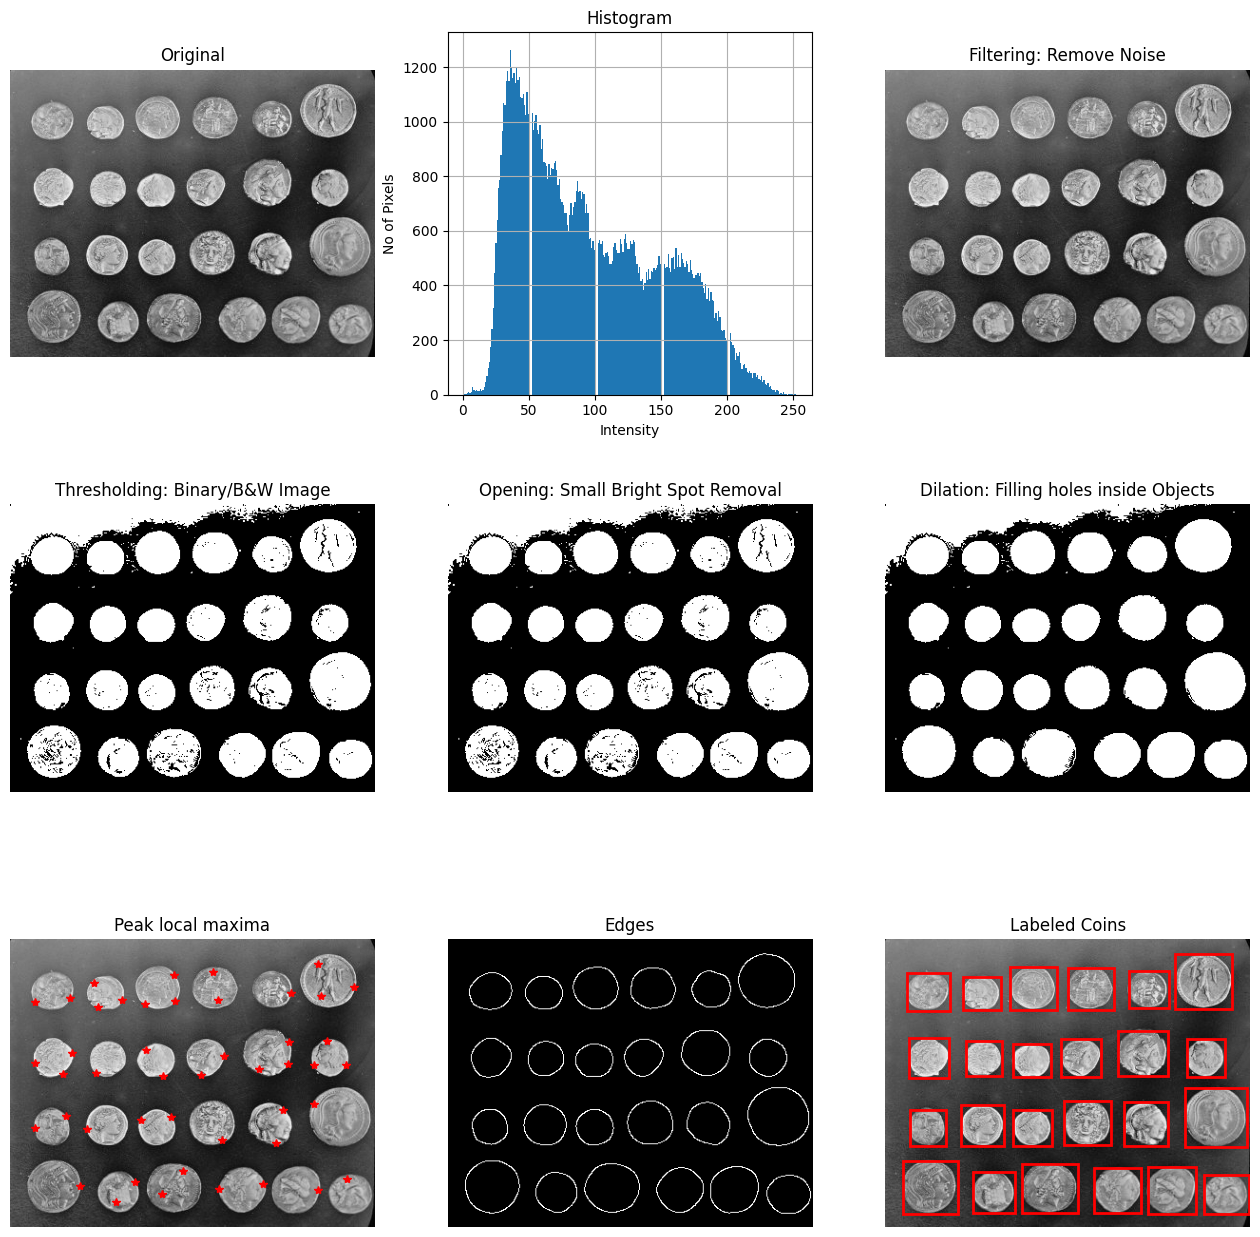

In [ ]:
image = data.coins()

fig, axes = plt.subplots(ncols=3, nrows=3,figsize=(16,16))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flat

ax0.imshow(image, cmap='gray')
ax0.set_title('Original',)
ax0.axis('off')

ax1.hist(image.flatten(),bins=256, lw=2,)
ax1.set_xlabel('Intensity')
ax1.set_ylabel('No of Pixels')
ax1.set_title('Histogram')
ax1.grid()

ax2.imshow(image, cmap='gray')
ax2.set_title('Filtering: Remove Noise')
ax2.axis('off')

thresh = filters.threshold_otsu(image)
bw = image.copy() > thresh

ax3.imshow(bw, cmap='gray')
ax3.set_title('Thresholding: Binary/B&W Image')
ax3.axis('off')

ax4.imshow(bw, cmap='gray')
ax4.set_title('Opening: Small Bright Spot Removal')
ax4.axis('off')

inverted = util.invert(bw)
dilation_seed = inverted.copy()
dilation_seed[1:-1,1:-1] = inverted.min()
mask = inverted
dilated_img = morphology.reconstruction(dilation_seed,mask,method='dilation')
bw = util.invert(dilated_img)

ax5.imshow(bw, cmap='gray')
ax5.set_title('Dilation: Filling holes inside Objects',)
ax5.axis('off')

coordinates = feature.peak_local_max(image, min_distance=20)

ax6.imshow(image, cmap=plt.cm.gray)
ax6.autoscale(False)
ax6.plot(coordinates[:, 1],coordinates[:, 0], c='r',ls='none',marker='*')
ax6.set_title('Peak local maxima',)
ax6.axis('off')

edges = feature.canny(image, sigma=3,low_threshold=10,high_threshold=80)

ax7.imshow(edges, cmap='gray')
ax7.set_title('Edges',)
ax7.axis('off')

label_image = morphology.label(edges)

ax8.imshow(image, cmap=plt.cm.gray)
ax8.set_title('Labeled Coins')
ax8.axis('off')

for region in measure.regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red',lw=2)
    ax8.add_patch(rect)

plt.show()

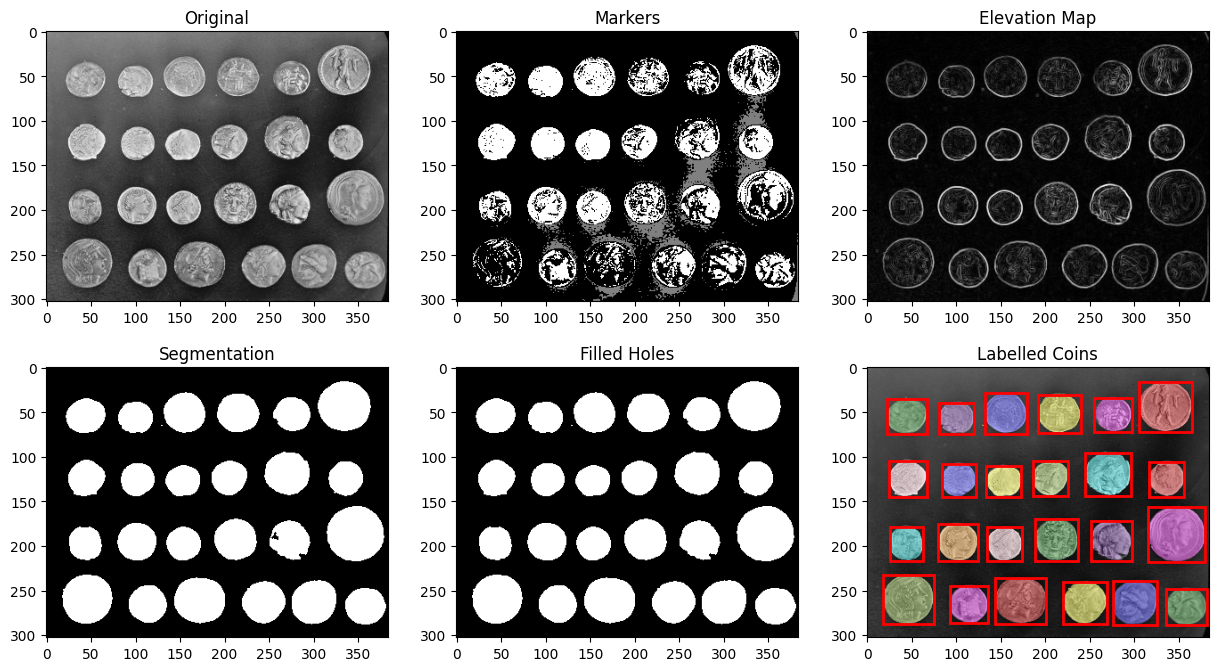

In [ ]:
coins = data.coins()
# convert to grayscale

f,ax = plt.subplots(2,3,figsize=(15,8))
ax = ax.ravel()
ax[0].imshow(coins,cmap='gray')
ax[0].set_title('Original')

# define markers as objects or not objects
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2

ax[1].imshow(markers,cmap='gray')
ax[1].set_title('Markers')

# apply sobel filter
elevation_map = filters.sobel(coins)

ax[2].imshow(elevation_map,cmap='gray')
ax[2].set_title('Elevation Map')

# apply watershed
seg = segmentation.watershed(elevation_map, markers)
ax[3].imshow(seg,cmap='gray')
ax[3].set_title('Segmentation')

# Fill holes or dilation
seg = ndimage.binary_fill_holes(seg - 1)
ax[4].imshow(seg,cmap='gray')
ax[4].set_title('Filled Holes')

# label the objects
labeled_coins, _ = ndimage.label(seg)
overlaid_img = color.label2rgb(labeled_coins,image=coins,bg_label=0)
ax[5].imshow(overlaid_img)
ax[5].set_title('Labelled Coins')

for region in measure.regionprops(labeled_coins):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax[5].add_patch(rect)

plt.show()

In [ ]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded) # 3rd convolution layer
x = UpSampling2D((2, 2))(x) # Pooling
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
autoencoder.fit(x_train, x_train,epochs=1,batch_size=128,shuffle=True,validation_data=(x_test, x_test))
# y is the image itself

469/469 [==============================] - 80s 167ms/step - loss: 0.6911 - val_loss: 0.6887


313/313 [==============================] - 5s 15ms/step


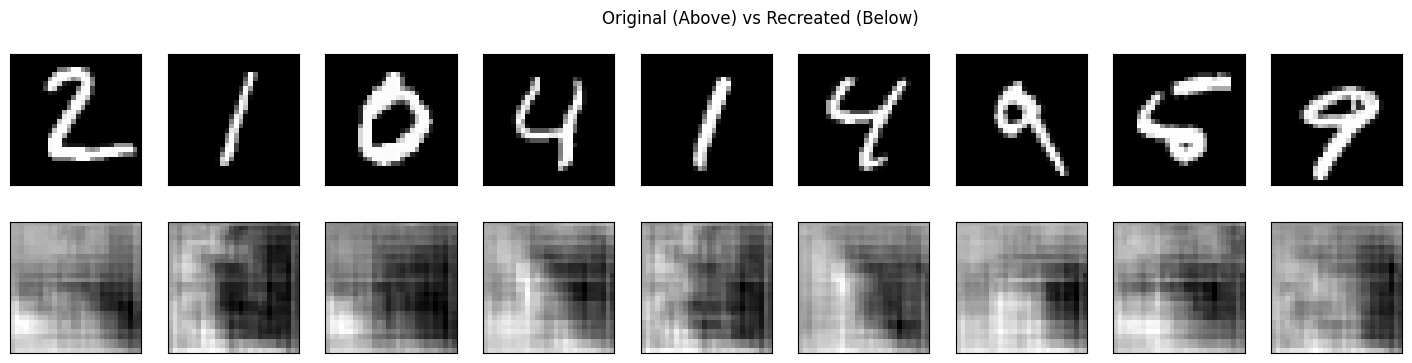

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
fig = plt.figure(figsize=(20, 4))
for i in range(1,n):
    # original image
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.suptitle('Original (Above) vs Recreated (Below)')
plt.show()

In [ ]:
sample = x_train[:50,:] # Get first 50 images
print(f'Our images are of size: {sample.shape}')
# Flatten the images
f_sample = sample.reshape(50,-1)/sample.max() # normalize
print(f'Each of our image has now {f_sample.shape[1]} Features')

Our images are of size: (50, 28, 28, 1)
Each of our image has now 784 Features


In [ ]:
dict_l = DictionaryLearning(n_components=36,fit_algorithm='lars',transform_algorithm='lasso_lars')
X_dict = dict_l.fit_transform(f_sample)

In [ ]:
print(f'We have found {X_dict.shape[1]} features from the old {f_sample.shape[1]} features')

We have found 36 features from the old 784 features


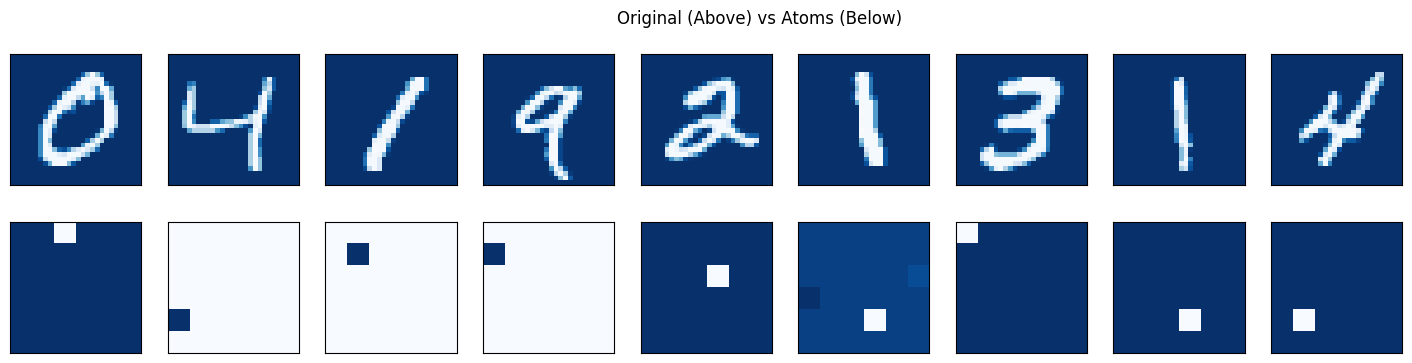

In [ ]:
n = 10
fig = plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    ax.imshow(sample[i].reshape(28, 28),cmap='Blues_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display dictonary
    ax = plt.subplot(2, n, i + n)
    ax.imshow(X_dict[i].reshape(6,6),cmap='Blues_r',interpolation='nearest') # 6*6 = 36
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig.suptitle('Original (Above) vs Atoms (Below)')
plt.show()